In [1]:
# Active Learning - Uncertainty Sampling

import numpy as np
import pandas as pd
import os
from warnings import simplefilter
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

from google.colab import drive


simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Συνδέομαι στο google drive για να μπορώ να αποθηκεύω και να ανακτώ μοντέλα από εκεί
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
# Καθορίζω την διαδρομή στο google drive και φορτώνω στην μνήμη το σύνολο των δεδομένων
path = 'drive/My Drive/bank_credit'
dt = pd.read_csv(os.path.join(path, 'creditcard.csv'))

In [4]:
# Επισκόπηση λίγων δεδομένων των δύο κλάσεων
a = dt.loc[dt['Class']==0].sample(3)
b = dt.loc[dt['Class']==1].sample(5)
c = pd.concat([a,b])
c

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
154953,103778.0,2.101117,-0.080222,-1.532466,0.146579,0.719741,0.183202,-0.126463,-0.070749,1.716395,-0.118856,0.823226,-2.089117,1.243127,1.944728,-1.209895,0.431972,-0.189135,0.359837,0.653458,-0.221027,-0.469276,-1.078375,0.245939,-0.428543,-0.210128,0.174084,-0.112213,-0.081030,5.49,0
231182,146645.0,1.923268,-0.197540,-1.834367,0.402033,0.166425,-0.787824,0.044354,-0.112272,1.187685,-0.841679,-0.703393,-0.348958,-1.278004,-1.213691,0.098567,0.024422,1.160996,0.130670,0.076640,-0.127537,-0.231482,-0.608704,0.189380,0.527513,-0.111718,-0.117865,-0.026146,-0.008602,62.72,0
135126,81119.0,1.191926,0.363893,0.551037,1.322588,-0.458617,-1.047686,0.182526,-0.248970,-0.107185,0.046930,-0.048129,0.522947,0.447686,0.257296,0.863654,0.034076,-0.380474,-0.230703,-0.604039,-0.101870,0.103108,0.345548,-0.083062,0.741309,0.642324,-0.303887,0.019776,0.028175,14.35,0
156990,109298.0,-1.000611,3.346850,-5.534491,6.835802,-0.299803,0.095951,-2.440419,1.286301,-2.766438,-4.458008,4.696533,-8.762113,0.985827,-7.320272,-1.063840,-3.371125,-4.251158,-0.430057,1.804013,1.189814,0.439757,-0.694099,0.299660,-0.657601,0.101648,0.430457,0.824685,0.326952,186.13,1
150680,93879.0,-12.833631,7.508790,-20.491952,7.465780,-11.575304,-5.140999,-14.020564,8.332120,-4.337713,-15.563791,7.610820,-15.592323,0.504789,-13.247889,-0.796526,-10.342328,-16.044524,-5.882136,1.573698,-1.378923,2.966842,0.615344,-0.766495,0.431261,-0.104975,-0.010091,-2.400811,-0.720557,104.03,1
17366,28658.0,-28.524268,15.876923,-29.468732,6.447591,-20.786000,-4.865613,-19.501084,18.748872,-3.642990,-7.939642,4.184674,-5.835075,1.215960,-5.330144,-0.118631,-5.367775,-11.431757,-4.696924,0.692688,1.706889,1.805770,-2.119376,-1.317450,0.169846,2.051687,-0.210502,1.301734,0.380246,99.99,1
150679,93879.0,-12.833631,7.508790,-20.491952,7.465780,-11.575304,-5.140999,-14.020564,8.332120,-4.337713,-15.563791,7.610820,-15.592323,0.504789,-13.247889,-0.796526,-10.342328,-16.044524,-5.882136,1.573698,-1.378923,2.966842,0.615344,-0.766495,0.431261,-0.104975,-0.010091,-2.400811,-0.720557,104.03,1
142557,84789.0,-1.430864,-0.802529,1.123320,0.389760,-0.281214,-0.055123,1.326232,0.195700,-0.546890,-0.713474,1.274629,0.023682,-1.521696,0.727242,0.166505,0.348038,-0.566390,0.216016,-1.140376,0.634184,0.325575,0.014002,0.844946,0.114963,0.156365,-0.619437,-0.120351,0.035594,354.33,1


In [5]:
# Δημιουργώ ένα χαρακτηριστικό πυκνότητας συναλλαγών (Density) και ένα πραγματικής ώρας (Actual Time)
# θεωρώντας ότι μπορεί να υπάρχει κάποια συσχέτιση με τις κακόβουλες κινήσεις
# Ενώ παράλληλα διαγράφω το χαρακτηριστικό Time
period = 30 * 60 # secs
half_period = int(period / 2)
a = np.histogram(dt['Time'], bins=np.linspace(0, 172800, 172801))[0]

density48h = [np.mean(a[[j % 172800 for j in range(-half_period, +half_period)]])]
for i in range(1, len(a)):
  density48h.append(density48h[-1] + (a[(i + half_period - 1) % 172800] - a[(i - half_period) % 172800]) / period)

density48h = np.array(density48h)
density48h = density48h / density48h.max()

dt['Density'] = density48h[dt['Time'].astype(int).values]
dt['Density'].reset_index(drop=True)
dt['Actual_Time'] = dt['Time'].apply(lambda x: np.mod(x, 86400) / 86400)

dt.drop('Time', inplace=True, axis='columns')

In [6]:
# Μετατρέπω το χαρακτηριστικό Amount με λογαριθμική κανονικοποίηση
amounts = dt['Amount'].copy()
dt['Amount'] = np.log(dt['Amount']+2)

In [7]:
# Χωρίζω το σύνολο δεδομένων σε εκπαίδευσης, επικύρωσης και ελέγχου
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
seed = 0

x_tr, x_te, y_tr, y_te = train_test_split(dt.loc[:, dt.columns != 'Class'], dt['Class'], test_size=.3, random_state=seed)

va_size = int(len(x_tr) * .05)
x_tr, x_UN = x_tr[:va_size], x_tr[va_size:]
y_tr, y_UN = y_tr[:va_size], y_tr[va_size:]

print(x_tr.shape, x_UN.shape, x_te.shape)

(9968, 31) (189396, 31) (85443, 31)


In [8]:
# Εκπαίδευση μοντέλου Logistic Regression στο αρχικό σύνολο δεδομένων και εκτύπωση στατιστικών.

y0 = y_tr[y_tr==0]
x0 = x_tr[y_tr==0]

y1 = y_tr[y_tr==1]
x1 = x_tr[y_tr==1]

ln = len(y1)

model = LogisticRegression(max_iter=1000)
model.fit(x_tr, y_tr)

y_preds = model.predict_proba(x_te.to_numpy())

y_preds = y_preds.argmax(axis=1)

print(confusion_matrix(y_te, y_preds).T)
print()
print(classification_report(y_te, y_preds))

[[85285    72]
 [   11    75]]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85296
           1       0.87      0.51      0.64       147

    accuracy                           1.00     85443
   macro avg       0.94      0.76      0.82     85443
weighted avg       1.00      1.00      1.00     85443



In [9]:
# Πρόβλεψη των πιθανοτήτων για όλα τα μη ετικετοποιημένα δεδομένα και επιλογή των 5000 πιο αβέβαιων

cost = 5000
cost_per_example = 1

preds = model.predict_proba(x_UN.to_numpy())

idx = np.argsort(np.abs(preds[:,0].flatten() - 0.5))[:int(cost/cost_per_example)]

In [10]:
# Εκπαίδευση του μοντέλου με τα νέα επαυξημένα δεδομένα και εκτύπωση στατιστικών.

x_ = np.vstack([x_UN.to_numpy()[idx], x_tr])
y_ = y_UN.to_numpy()[idx].tolist() + y_tr.to_list()

model_ = LogisticRegression(max_iter=1000)
model_.fit(x_, y_)

y_preds_ = model_.predict_proba(x_te.to_numpy())

y_preds_ = y_preds_.argmax(axis=1)

print(confusion_matrix(y_te, y_preds_).T)
print()
print(classification_report(y_te, y_preds_))


[[85268    48]
 [   28    99]]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85296
           1       0.78      0.67      0.72       147

    accuracy                           1.00     85443
   macro avg       0.89      0.84      0.86     85443
weighted avg       1.00      1.00      1.00     85443



In [12]:
# Σταδιακή επέκταση των δεδομένων εκπαίδευσης σε 100 βήματα (ανά 50 δείγματα) και εκτύπωση στατιστικών.

cost = 5000
cost_per_example = 1


sps = np.linspace(0, int(cost/cost_per_example), 101)
x_rest = x_UN.to_numpy()
y_rest = y_UN.to_numpy()
x_ = x_tr.to_numpy()
y_ = y_tr.to_numpy()

pos = []
neg = []
for i in range(len(sps)-1):
  print(f'{i+1}/{len(sps)-1}...')
  sp = int(sps[i+1] - sps[i])

  preds = model.predict_proba(x_rest)

  idx = np.argsort(np.abs(preds[:,0].flatten() - 0.5))[:sp]

  x_ = np.vstack([x_rest[idx], x_])
  y_ = np.array(y_rest[idx].tolist() + y_.tolist())

  model_ = LogisticRegression(max_iter=1000)
  model_.fit(x_, y_)

  y_preds_ = model_.predict_proba(x_te.to_numpy())

  y_preds_ = y_preds_.argmax(axis=1)

  cm = confusion_matrix(y_te, y_preds_).T
  pos.append(cm[0,1])
  neg.append(cm[1,0])

  print(f'Μετά από πρόσθεση {i+1}x{int(cost/(len(sps)-1))} παραδειγμάτων...')
  print(cm)
  print()
  print(classification_report(y_te, y_preds_))
  print(50*'-')

  x_rest = np.delete(x_rest, idx, axis=0)
  y_rest = np.delete(y_rest, idx, axis=0)

1/100...
Μετά από πρόσθεση 1x50 παραδειγμάτων...
[[85286    61]
 [   10    86]]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85296
           1       0.90      0.59      0.71       147

    accuracy                           1.00     85443
   macro avg       0.95      0.79      0.85     85443
weighted avg       1.00      1.00      1.00     85443

--------------------------------------------------
2/100...
Μετά από πρόσθεση 2x50 παραδειγμάτων...
[[85284    56]
 [   12    91]]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85296
           1       0.88      0.62      0.73       147

    accuracy                           1.00     85443
   macro avg       0.94      0.81      0.86     85443
weighted avg       1.00      1.00      1.00     85443

--------------------------------------------------
3/100...
Μετά από πρόσθεση 3x50 παραδειγμάτων...
[[85284    56]
 [   12    91]]

 

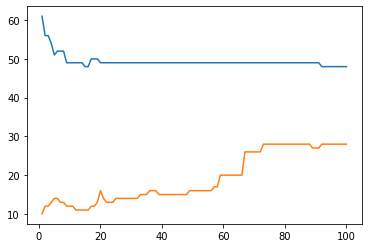

In [13]:
plt.plot(range(1, len(sps)), pos)
plt.plot(range(1, len(sps)), neg)

In [14]:
# Σταδιακή επέκταση των δεδομένων εκπαίδευσης σε 100 βήματα (ανά 50 δείγματα) και εκτύπωση στατιστικών.

cost = 5000
cost_per_example = 1


sps = np.linspace(0, int(cost/cost_per_example), 101)
x_rest = x_UN.to_numpy()
y_rest = y_UN.to_numpy()
x_ = x_tr.to_numpy()
y_ = y_tr.to_numpy()

pos_rnd = []
neg_rnd = []
for i in range(len(sps)-1):
  print(f'{i+1}/{len(sps)-1}...')
  sp = int(sps[i+1] - sps[i])

  preds = model.predict_proba(x_rest)

  idx = np.argsort(np.abs(preds[:,0].flatten() - 0.5))[:4 * sp]
  np.random.shuffle(idx)
  idx = idx[:sp]

  x_ = np.vstack([x_rest[idx], x_])
  y_ = np.array(y_rest[idx].tolist() + y_.tolist())

  model_ = LogisticRegression(max_iter=1000)
  model_.fit(x_, y_)

  y_preds_ = model_.predict_proba(x_te.to_numpy())

  y_preds_ = y_preds_.argmax(axis=1)

  cm = confusion_matrix(y_te, y_preds_).T
  pos_rnd.append(cm[0,1])
  neg_rnd.append(cm[1,0])

  print(f'Μετά από πρόσθεση {i+1}x{int(cost/(len(sps)-1))} παραδειγμάτων...')
  print(cm)
  print()
  print(classification_report(y_te, y_preds_))
  print(50*'-')

  x_rest = np.delete(x_rest, idx, axis=0)
  y_rest = np.delete(y_rest, idx, axis=0)

1/100...
Μετά από πρόσθεση 1x50 παραδειγμάτων...
[[85283    56]
 [   13    91]]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85296
           1       0.88      0.62      0.73       147

    accuracy                           1.00     85443
   macro avg       0.94      0.81      0.86     85443
weighted avg       1.00      1.00      1.00     85443

--------------------------------------------------
2/100...
Μετά από πρόσθεση 2x50 παραδειγμάτων...
[[85282    55]
 [   14    92]]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85296
           1       0.87      0.63      0.73       147

    accuracy                           1.00     85443
   macro avg       0.93      0.81      0.86     85443
weighted avg       1.00      1.00      1.00     85443

--------------------------------------------------
3/100...
Μετά από πρόσθεση 3x50 παραδειγμάτων...
[[85283    55]
 [   13    92]]

 

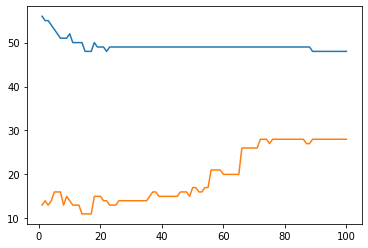

In [15]:
plt.plot(range(1, len(sps)), pos_rnd)
plt.plot(range(1, len(sps)), neg_rnd)

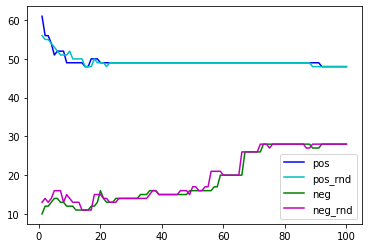

In [17]:
plt.plot(range(1, len(sps)), pos, color='b', label='pos')
plt.plot(range(1, len(sps)), pos_rnd, color='c', label='pos_rnd')

plt.plot(range(1, len(sps)), neg, color='g', label='neg')
plt.plot(range(1, len(sps)), neg_rnd, color='m', label='neg_rnd')

plt.legend()